In [156]:
import pandas as pd
import numpy as np
import re

def paranthesis_remover(entry):
    return re.sub('\(.+?\)', '', str(entry))

def one_hot_encoder(file_name):
    imdb_budget_df = pd.read_csv(file_name)
    
    # Include only movies, and successful API calls
    reduced_imdb = imdb_budget_df.loc[imdb_budget_df['Response'] == True]
    reduced_imdb = imdb_budget_df.loc[imdb_budget_df['Type'] == 'movie']
    
    # drop extra columns
    reduced_imdb.columns = map(str.lower, reduced_imdb.columns)
    return reduced_imdb.drop(columns=['actors', 'dvd', 'writer', 'unnamed: 0', 'awards',
                                      'plot', 'error', 'poster', 'production',
                                      'rated', 'released', 'response',
                                      'type', 'website', 'imdbid', 'totalseasons'])
    

In [157]:
imdb = one_hot_encoder('raw_data/combined_imdb_data.csv')

In [158]:
def preprocess(df):
    df['boxoffice'] = df['boxoffice'].apply(lambda x: ''.join([ch for ch in x if ch.isdigit()]))
    return df

budget_df = imdb.dropna(subset=['boxoffice'])
budget_df = preprocess(budget_df)

C:\Users\Harjee\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [159]:
oscar_data = pd.read_csv('./processed_data/oscar_data.csv').rename(columns={"entity": "title", "category": "nominated", "winner": "won"})

In [160]:
budget_df = pd.merge(budget_df, foreign_oscars, how='inner', on='title')


In [161]:
def grab_first(entry):
    return entry.split(',')[0]

budget_df['country'] = budget_df['country'].apply(grab_first)

C:\Users\Harjee\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


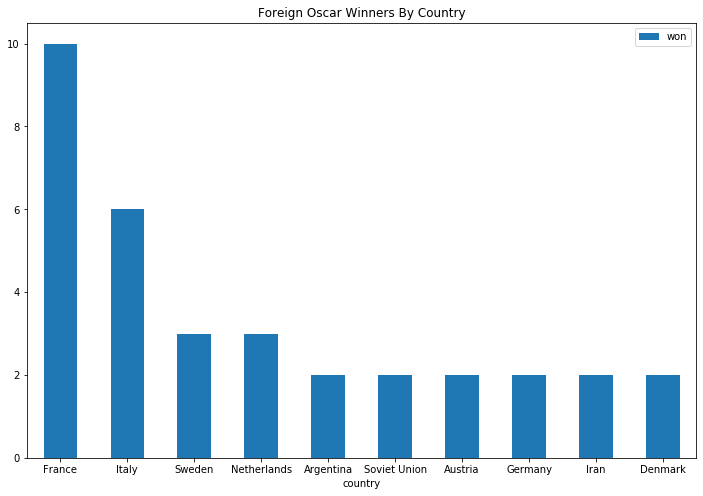

In [162]:
import matplotlib.pyplot as plt

foid = foreign_oscar_imdb_df[['country', 'won', 'year_x']]
foid.sort_values('year_x', inplace=True)
foid = foid[foid['won'] == True]

winning_countries = foid.groupby(['country']).sum()
winning_countries = winning_countries.reset_index().sort_values('won', ascending=False)
winning_countries = winning_countries.nlargest(10, columns='won')
winning_countries.plot(x='country', y='won', kind='bar', rot=0, figsize=(12, 8), title='Foreign Oscar Winners By Country')

In [163]:
def grab_first_two(entry):
    return ','.join(sorted(entry.split(',')[0:1]))
    
budget_df['genre'] = budget_df['genre'].apply(grab_first_two)
budget_df['director'] = budget_df['director'].apply(grab_first)
budget_df['language'] = budget_df['language'].apply(grab_first)

C:\Users\Harjee\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


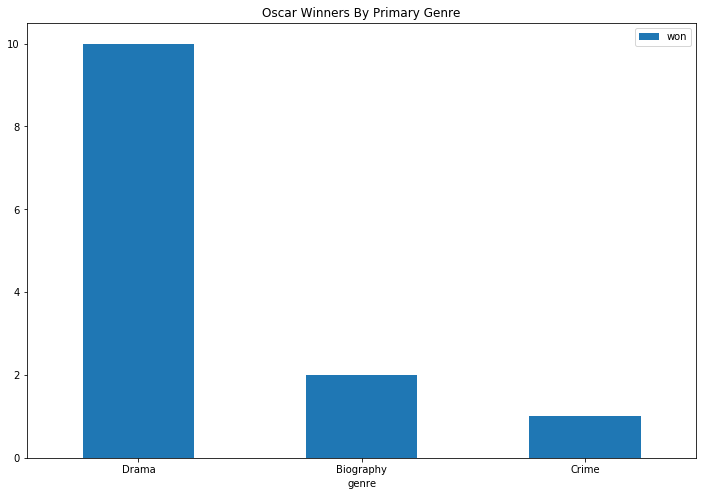

In [165]:
genre_df = budget_df[['genre', 'won', 'year_x']]
genre_df.sort_values('year_x', inplace=True)
genre_df = genre_df[genre_df['won'] == True]

winning_genres = genre_df.groupby(['genre']).sum()
winning_genres = winning_genres.reset_index().sort_values('won', ascending=False)
winning_genres = winning_genres.nlargest(10, columns='won')
winning_genres.plot(x='genre', y='won', kind='bar', rot=0, figsize=(12, 8), title='Oscar Winners By Primary Genre')

In [ ]:
from sklearn.decomposition import PCA

PCA(n_)